# 1. Исследовательский анализ данных

In [16]:
pip install ipyplot

Note: you may need to restart the kernel to use updated packages.


In [17]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import ipyplot
import numpy as np

In [5]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [6]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Размер выборки - 7591 фотография 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9e1c506890>]],
      dtype=object)

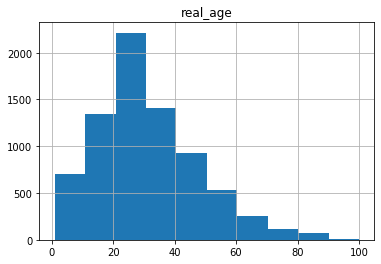

In [7]:
labels.hist()

In [8]:
datagen = ImageDataGenerator(rescale=1./255)
datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [9]:
features, target = next(datagen_flow)

In [10]:
features

array([[[[0.5764706 , 0.5137255 , 0.454902  ],
         [0.53333336, 0.47058827, 0.41176474],
         [0.5294118 , 0.4666667 , 0.40784317],
         ...,
         [0.48235297, 0.4156863 , 0.30588236],
         [0.49411768, 0.427451  , 0.31764707],
         [0.49803925, 0.43137258, 0.32156864]],

        [[0.5176471 , 0.454902  , 0.39607847],
         [0.5058824 , 0.4431373 , 0.38431376],
         [0.5529412 , 0.4901961 , 0.43137258],
         ...,
         [0.49803925, 0.43137258, 0.32156864],
         [0.50980395, 0.4431373 , 0.33333334],
         [0.50980395, 0.4431373 , 0.33333334]],

        [[0.5176471 , 0.45098042, 0.38823533],
         [0.5058824 , 0.43921572, 0.37647063],
         [0.5176471 , 0.45098042, 0.38823533],
         ...,
         [0.5019608 , 0.43529415, 0.3254902 ],
         [0.50980395, 0.4431373 , 0.33333334],
         [0.5058824 , 0.43921572, 0.32941177]],

        ...,

        [[0.06666667, 0.45882356, 0.52156866],
         [0.08235294, 0.47450984, 0.5372549 ]

In [11]:
target

array([50, 41, 46, 85, 14, 40, 14, 53,  4, 32, 14, 23, 37, 62, 21, 58, 43,
       32, 25, 94, 30, 16, 23, 18, 41, 24, 26, 14, 36, 28, 78, 13])

In [18]:
from PIL import Image
images = [Image.fromarray((img * 255).astype(np.uint8)) for img in features]


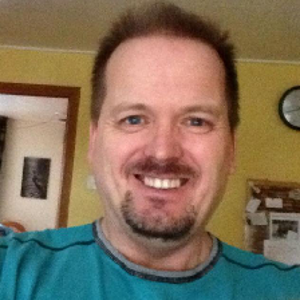
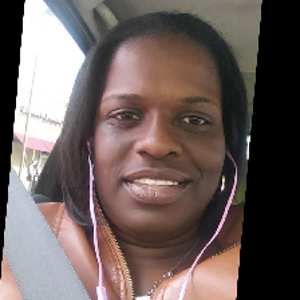
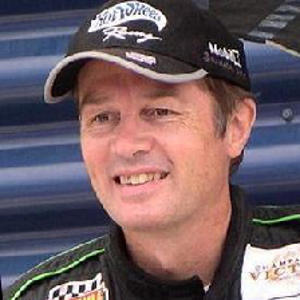
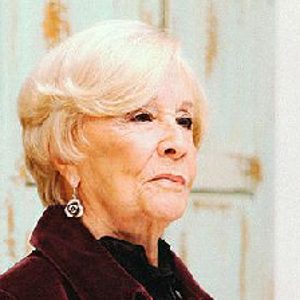
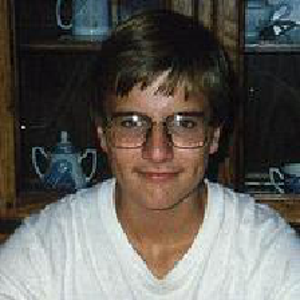
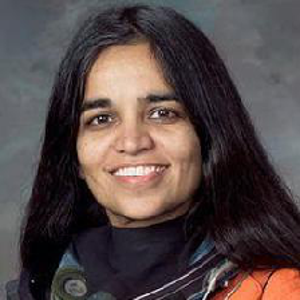
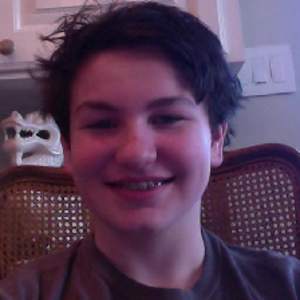
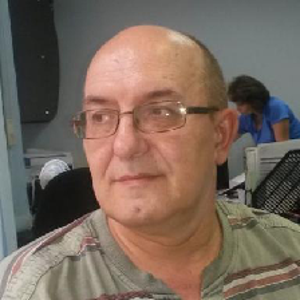
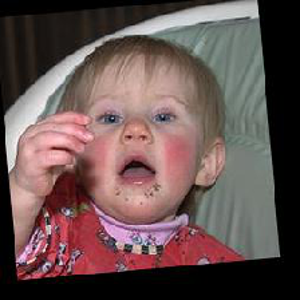
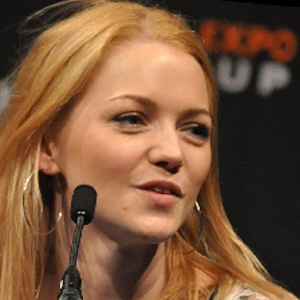
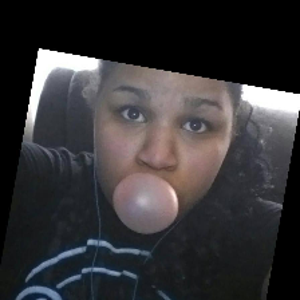
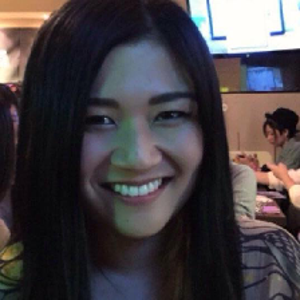
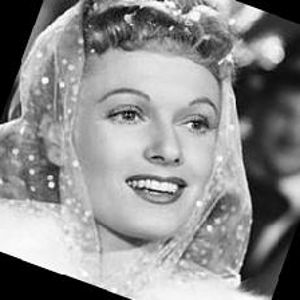
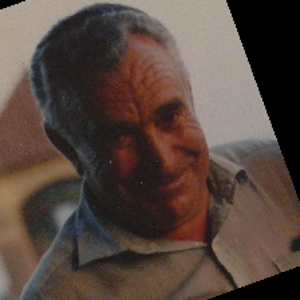
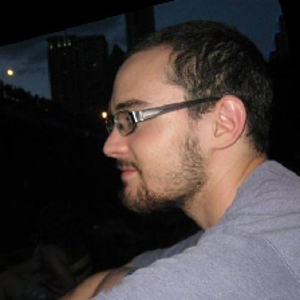

In [19]:
ipyplot.plot_images(images, target, max_images = 15, img_width = 150)

    Исходя из гистограммы, можно сделать вывод, что данные распределены нормально с положительной скошенностью. Пик возраста один - 20-30 лет. Большая часть представленных лиц принадлжеит людям между 20 и 40. Также стоит отметить разнообразие группы от 0-20. Лиц в этой возрастной категории представлено больше, чем в интервалах 40-60, 60-80 или 80-100. Лиц пожилых людей после 60-ти в  данных мало.
    На мой взгляд, для улучшения качества прогноза стоит уравнять количество лиц всех возрастных категорий поровну, потому что на лицо дисбаланс классов. Если бы в тестовых данных лица по возрасту были бы распределены равномерно, то результаты получились бы хуже. Я считаю, что к уже существующим данным стоит добавить фото возрастных категорий 0-20, 40-60, 80-100, но получившееся число лиц в каждой из перечисленных категорий не должно быть больше кол-ва уже существующих лиц 20-40. 
    Из представленных фото, некторые несколько перевернуты набок, видимо это было сделано специально для имитауции наклонов головы. 
    В качестве аугментации для улучшения модели можно добавить еще поворотов головы, но не более, чем на 45 градусов, т.к. большие углы > 45 градусов нетипичны для фото и скорей ухудшат модель. Часть фотографий можно отразить по горизонтали, т.к. имеют место быть фото, отраженные на зеркальной поверхности. Также повысить качество можно путем сдвигиов изображения в разные стороны. На мой взгляд, пойдут сдвиги по горизонтали и вертикали до 30 % от раземера . 
    

# 2. Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

# обучение возрастного классификатора Resnet50
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import   Conv2D, Flatten, AvgPool2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator #загруузчик
from tensorflow.keras.applications.resnet import ResNet50 



def load_train(path):
    labels = pd.read_csv(path+'labels.csv')                                                     
    train_datagen = ImageDataGenerator(rescale= 1./255, validation_split=0.25)  
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training', # установил subset='training', чтобы тест и трейн отличались
        seed=12345)

    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path+'labels.csv')  
    test_datagen = ImageDataGenerator(rescale= 1./255, validation_split=0.25)  # Удалл validation split
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation', # установил subset='validation', чтобы тест и трейн отличались
        seed=12345)
    
    return test_datagen_flow

def create_model(input_shape):
    
    backbone = ResNet50(input_shape= input_shape,
                    weights='imagenet', 
                    include_top= False)  # без кол ва классов
                     
    # замораживаем ResNet50 без верхушки
    #backbone.trainable = False
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    #model.add(Flatten())                       # не было flatten
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mean_squared_error',metrics=['mae']) #пожно поменять на mean_absolute_error
    

    return model
    
    
def train_model(model, train_data, test_data, batch_size=None, epochs= 10,
                steps_per_epoch=None, validation_steps=None):
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data, 
              validation_data= test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2) #shuffle=True   
    return model

```

```

<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/10
2020-07-04 12:45:47.129465: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2020-07-04 12:45:51.241982: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 114s - loss: 223.5054 - mae: 10.9005 - val_loss: 772.6603 - val_mae: 22.8732
Epoch 2/10
178/178 - 41s - loss: 105.6365 - mae: 7.8232 - val_loss: 563.4827 - val_mae: 18.6972
Epoch 3/10
178/178 - 42s - loss: 70.3511 - mae: 6.4285 - val_loss: 436.7586 - val_mae: 15.8222
Epoch 4/10
178/178 - 41s - loss: 43.4818 - mae: 5.0986 - val_loss: 190.5751 - val_mae: 10.2861
Epoch 5/10
178/178 - 41s - loss: 28.4115 - mae: 4.1289 - val_loss: 134.4777 - val_mae: 8.8340
Epoch 6/10
178/178 - 40s - loss: 21.2809 - mae: 3.5301 - val_loss: 92.1605 - val_mae: 7.4565
Epoch 7/10
178/178 - 41s - loss: 16.9759 - mae: 3.1752 - val_loss: 77.2380 - val_mae: 6.7141
Epoch 8/10
178/178 - 41s - loss: 13.7462 - mae: 2.8669 - val_loss: 82.3518 - val_mae: 6.8609
Epoch 9/10
178/178 - 40s - loss: 11.7553 - mae: 2.6219 - val_loss: 129.4821 - val_mae: 8.6678
Epoch 10/10
178/178 - 41s - loss: 11.2165 - mae: 2.5402 - val_loss: 81.0340 - val_mae: 6.8373
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 11s - loss: 81.0340 - mae: 6.8373
Test MAE: 6.8373
```

# 3. Анализ обученной модели

Обученная модель показала ошибку в рамках допустимого диапозона. MAE составила 6.83.  Насколько я понял, можно было оставить 7 эпох, т.к. после 7ой она начала переобучаться. В качестве функции потерь использовалась MSE, т.к. говорят, что нейросети обучаются быстрей на ней, чем на MAE. 